In [35]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(22)

means=[[2,2],[4,2]]
cov=[[.7,0],[0,.7]]
N=20

X0=np.random.multivariate_normal(means[0],cov,N)
X1=np.random.multivariate_normal(means[1],cov,N)
X=np.concatenate((X0,X1),axis=0)
y=np.concatenate((np.ones(N),-np.ones(N)),axis=0)


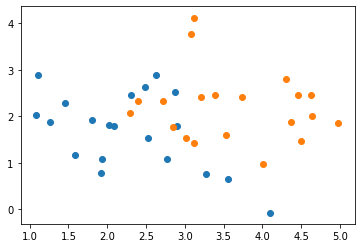

In [2]:
plt.scatter(X0[:,0],X0[:,1])
plt.scatter(X1[:,0],X1[:,1])
plt.show()

# Solving by sklearn

In [6]:
from sklearn.svm import SVC
C=100
clf=SVC(kernel='linear',C=C)
clf.fit(X,y)
w_sklearn=clf.coef_.reshape(-1,1)
b_sklearn=clf.intercept_[0]
print(w_sklearn,'\n',b_sklearn)

[[-1.87461946]
 [-1.80697358]] 
 8.496911901960104


# Solving by dual problem


In [15]:
from cvxopt import matrix,solvers


#build K
V=np.concatenate((X0,-X1),axis=0)
K=matrix(V.dot(V.T))
p=matrix(-np.ones((2*N,1)))

#build A,b,G,h
G=matrix(np.vstack((-np.eye(2*N),np.eye(2*N))))
h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A=matrix(y.reshape(-1,2*N))
b=matrix(np.zeros((1,1)))

solvers.options['show_progress']=False
sol=solvers.qp(K,p,G,h,A,b)
l=np.array(sol['x']).reshape(2*N,1) #lamda vector

#support set
S=np.where(l>1e-5)[0]
S2=np.where(l<.999*C)[0]

#margin set
M = [val for val in S if val in S2] # intersection of two lists
VS = V[S] # shape (NS, d)
lS = l[S] # shape (NS,)
w_dual = lS.reshape(1,-1).dot(VS) # shape (d,)
w_dual=w_dual.reshape(2,)
yM = y[M] # shape(NM,)
XM = X[M] # shape(NM, d)
b_dual = np.mean(yM - XM.dot(w_dual)) # shape (1,)
print('w_dual = ', w_dual)
print('_dual = ', b_dual)

w_dual =  [-1.87457279 -1.80695039]
_dual =  8.496721098145423


# Giai bang toi uu ko rang buoc


In [58]:
np.random.seed(22)

means=[[2,2],[4,2]]
cov=[[.7,0],[0,.7]]
N=20

X0=np.random.multivariate_normal(means[0],cov,N)
X1=np.random.multivariate_normal(means[1],cov,N)
X=np.concatenate((X0,X1),axis=0)
y=np.concatenate((np.ones(N),-np.ones(N)),axis=0)

C=100
lam=1/C
def loss(X,y,w,b):
    """
    X: shape(2N,d)
    y: shape(2N,)
    w: shape(d,)
    b is a scalar
    """
    a=1-y*(X.dot(w)+b)
    mask=a<0
    a[mask]=0
    return (sum(a)+.5*lam*w.dot(w))/X.shape[0]

def grad(X,y,w,b):
    z=X.dot(w)+b #shape(2N,)
    yz=y*z
    active_set=np.where(yz<=1)[0]
    _yX=-X*y[:,np.newaxis]
    
    grad_w=(np.sum(_yX[active_set],axis=0)+lam*w)/X.shape[0]
    grad_b=(-np.sum(y[active_set]))/X.shape[0]
    
    return grad_w,grad_b

def soft_margin_SVM(X,y,w_init,b_init,eta=0.05):
    w=w_init
    b=b_init
    loss_his=[loss(X,y,w,b)]
    it=0
    while it<=10000:
        it+=1
        grad_w,grad_b=grad(X,y,w,b)
        w=w-eta*grad_w
        b=b-eta*grad_b
        if it%1000==0:
            print('iter:',it,',loss:',loss(X,y,w,b))
            loss_his.append(loss(X,y,w,b))
    return w,b,loss_his
w_init=.1*np.random.rand(X.shape[1])
b_init=.1*np.random.rand()
w,b,loss_his=soft_margin_SVM(X,y,w_init,b_init)

iter: 1000 ,loss: 0.43640835477201145
iter: 2000 ,loss: 0.40529065426491817
iter: 3000 ,loss: 0.3998439275077987
iter: 4000 ,loss: 0.3951870928938118
iter: 5000 ,loss: 0.3939443444890992
iter: 6000 ,loss: 0.39384981837074523
iter: 7000 ,loss: 0.3938800489056252
iter: 8000 ,loss: 0.3938331557221531
iter: 9000 ,loss: 0.39397228602464707
iter: 10000 ,loss: 0.39372302945225973


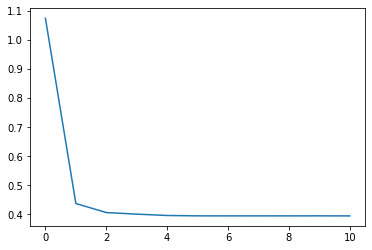

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_his)),loss_his)
plt.show()

In [60]:
print(w,b)

[-1.36845863 -1.32014833] 6.483185273751131
